# Epilogue Apache Spark 3.0

At the time we were writing this book, Apache Spark 3.0 had not yet been officially
released; it was still under development, and we got to work with Spark 3.0.0-
preview2. All the code samples in this book have been tested against Spark 3.0.0-
preview2, and they should work no differently with the official Spark 3.0 release.
Whenever possible in the chapters, where relevant, we mentioned when features were
new additions or behaviors in Spark 3.0. In this chapter, we survey the changes.

The bug fixes and feature enhancements are numerous, so for brevity, we highlight
just a selection of the notable changes and features pertaining to Spark components.
Some of the new features are, under the hood, advanced and beyond the scope of this
book, but we mention them here so you can explore them when the release is gener‐
ally available.

## Spark Core and Spark SQL
Let’s first consider what’s new under the covers. A number of changes have been
introduced in Spark Core and the Spark SQL engine to help speed up queries. One
way to expedite queries is to read less data using dynamic partition pruning. Another
is to adapt and optimize query plans during execution.

### Dynamic Partition Pruning
The idea behind dynamic partition pruning (DPP) is to skip over the data you don’t
need in a query’s results. The typical scenario where DPP is optimal is when you are
joining two tables: a fact table (partitioned over multiple columns) and a dimension
table (nonpartitioned), as shown in Figure 12-1. Normally, the filter is on the nonpar‐
titioned side of the table (Date, in our case). For example, consider this common
query over two tables, Sales and Date:
~~~
-- In SQL
SELECT * FROM Sales JOIN ON Sales.date = Date.date
~~~
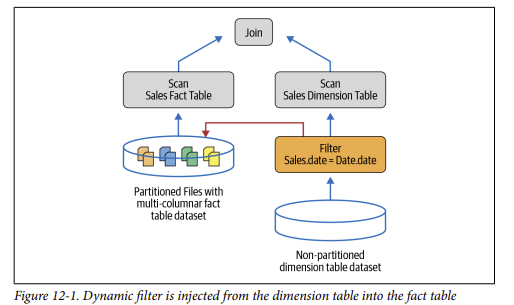
The key optimization technique in DPP is to take the result of the filter from the
dimension table and inject it into the fact table as part of the scan operation to limit
the data read, as shown in Figure 12-1.

Consider a case where the dimension table is smaller than the fact table and we per‐
form a join, as shown in Figure 12-2. In this case, Spark most likely will do a broad‐
cast join (discussed in Chapter 7). During this join, Spark will conduct the following
steps to minimize the amount of data scanned from the larger fact table:
1. On the dimension side of the join, Spark will build a hash table from the dimen‐
sion table, also known as the build relation, as part of this filter query.
2. Spark will plug the result of this query into the hash table and assign it to a
broadcast variable, which is distributed to all executors involved in this join
operation.
3. On each executor, Spark will probe the broadcasted hash table to determine what
corresponding rows to read from the fact table.
4. Finally, Spark will inject this filter dynamically into the file scan operation of the
fact table and reuse the results from the broadcast variable. This way, as part of
the file scan operation on the fact table, only the partitions that match the filter
are scanned and only the data needed is read.
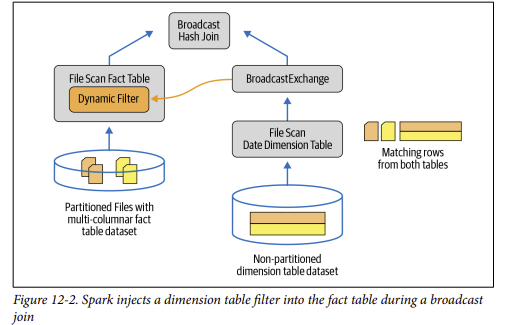
Enabled by default so that you don’t have to explicitly configure it, all this happens
dynamically when you perform joins between two tables. With the DPP optimization,
Spark 3.0 can work much better with star-schema queries.

### Adaptive Query Execution
Another way Spark 3.0 optimizes query performance is by adapting its physical exe‐
cution plan at runtime. Adaptive Query Execution (AQE) reoptimizes and adjusts
query plans based on runtime statistics collected in the process of query execution. It
attempts to to do the following at runtime:
* Reduce the number of reducers in the shuffle stage by decreasing the number of
shuffle partitions.
* Optimize the physical execution plan of the query, for example by converting a
SortMergeJoin into a BroadcastHashJoin where appropriate.
* Handle data skew during a join.

All these adaptive measures take place during the execution of the plan at runtime, as
shown in Figure 12-3. To use AQE in Spark 3.0, set the configuration
spark.sql.adaptive.enabled to true.
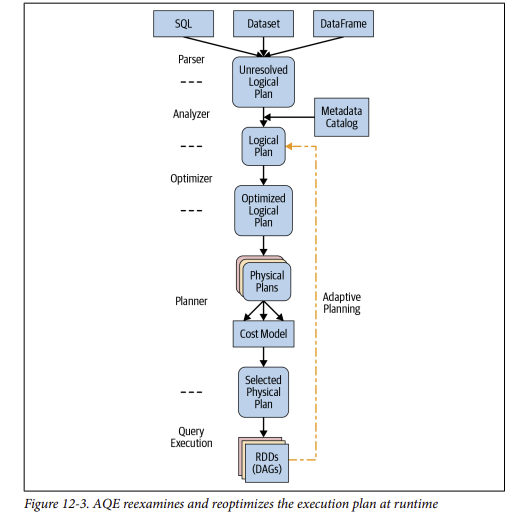
#### The AQE framework
Spark operations in a query are pipelined and executed in parallel processes, but a
shuffle or broadcast exchange breaks this pipeline, because the output of one stage is
needed as input to the next stage (see “Step 3: Understanding Spark Application Con‐
cepts” on page 25 in Chapter 2). These breaking points are called materialization
points in a query stage, and they present an opportunity to reoptimize and reexamine
the query, as illustrated in Figure 12-4.
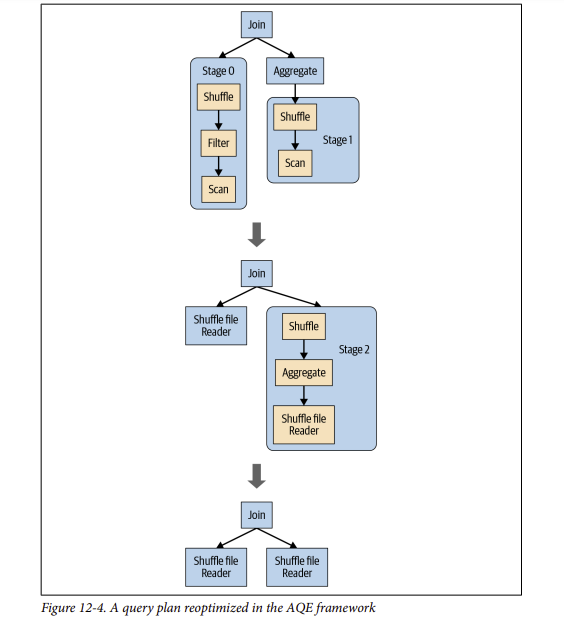
Here are the conceptual steps the AQE framework iterates over, as depicted in this
figure:
1. All the leaf nodes, such as scan operations, of each stage are executed.
2. Once the materialization point finishes executing, it’s marked as complete, and all
the relevant statistics garnered during execution are updated in its logical plan.
3. Based on these statistics, such as number of partitions read, bytes of data read,
etc., the framework runs the Catalyst optimizer again to understand whether it
can:
* a. Coalesce the number of partitions to reduce the number of reducers to read
shuffle data.
* b. Replace a sort merge join, based on the size of tables read, with a broadcast
join.
* c. Try to remedy a skew join.
* d. Create a new optimized logical plan, followed by a new optimized physical
plan.

This process is repeated until all the stages of the query plan are executed.

In short, this reoptimization is done dynamically, as shown in Figure 12-3, and the
objective is to dynamically coalesce the shuffle partitions, decrease the number of
reducers needed to read the shuffle output data, switch join strategies if appropriate,
and remedy any skew joins.

Two Spark SQL configurations dictate how AQE will reduce the number of reducers:
* spark.sql.adaptive.coalescePartitions.enabled (set to true)
* spark.sql.adaptive.skewJoin.enabled (set to true)

At the time of writing, the Spark 3.0 community blog, documentation, and examples
had not been published publicly, but by the time of publication they should have
been. These resources will enable you to get more detailed information if you wish to
see how these features work under the hood—including on how you can inject SQL
join hints, discussed next.

### SQL Join Hints
Adding to the existing BROADCAST hints for joins, Spark 3.0 adds join hints for all
Spark join strategies (see “A Family of Spark Joins” on page 187 in Chapter 7). Exam‐
ples are provided here for each type of join.
#### Shuffle sort merge join (SMJ)
With these new hints, you can suggest to Spark that it perform a SortMergeJoin
when joining tables a and b or customers and orders, as shown in the following
examples. You can add one or more hints to a SELECT statement inside /*+ ... */
comment blocks:
~~~
SELECT /*+ MERGE(a, b) */ id FROM a JOIN b ON a.key = b.key
SELECT /*+ MERGE(customers, orders) */ * FROM customers, orders WHERE
 orders.custId = customers.custId
 ~~~
#### Broadcast hash join (BHJ)
Similarly, for a broadcast hash join, you can provide a hint to Spark that you prefer a
broadcast join. For example, here we broadcast table a to join with table b and table
customers to join with table orders:
~~~
SELECT /*+ BROADCAST(a) */ id FROM a JOIN b ON a.key = b.key
SELECT /*+ BROADCAST(customers) */ * FROM customers, orders WHERE
 orders.custId = customers.custId
 ~~~
#### Shuffle hash join (SHJ)
You can offer hints in a similar way to perform shuffle hash joins, though this is less
commonly encountered than the previous two supported join strategies:
~~~
SELECT /*+ SHUFFLE_HASH(a, b) */ id FROM a JOIN b ON a.key = b.key
SELECT /*+ SHUFFLE_HASH(customers, orders) */ * FROM customers, orders WHERE
 orders.custId = customers.custId
 ~~~
#### Shuffle-and-replicate nested loop join (SNLJ)
Finally, the shuffle-and-replicate nested loop join adheres to a similar form and
syntax:
~~~
SELECT /*+ SHUFFLE_REPLICATE_NL(a, b) */ id FROM a JOIN b
~~~

### Catalog Plugin API and DataSourceV2
Not to be confined only to the Hive metastore and catalog, Spark 3.0’s experimental
DataSourceV2 API extends the Spark ecosystem and affords developers three core
capabilities. Specifically, it:
* Enables plugging in an external data source for catalog and table management
* Supports predicate pushdown to additional data sources with supported file for‐
mats like ORC, Parquet, Kafka, Cassandra, Delta Lake, and Apache Iceberg.
* Provides unified APIs for streaming and batch processing of data sources for
sinks and sources

Aimed at developers who want to extend Spark’s ability to use external sources and
sinks, the Catalog API provides both SQL and programmatic APIs to create, alter,
load, and drop tables from the specified pluggable catalog. The catalog provides a
hierarchical abstraction of functionalities and operations performed at different lev‐
els, as shown in Figure 12-5.
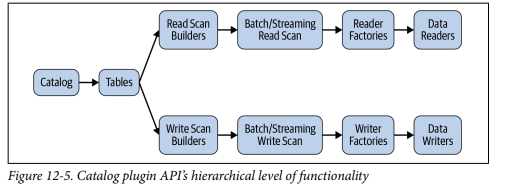
The initial interaction between Spark and a specific connector is to resolve a relation
to its actual Table object. Catalog defines how to look up tables in this connector.
Additionally, Catalog can define how to modify its own metadata, thus enabling
operations like CREATE TABLE, ALTER TABLE, etc.

For example, in SQL you can now issue commands to create namespaces for your cat‐
alog. To use a pluggable catalog, enable the following configs in your sparkdefaults.conf file:
~~~
spark.sql.catalog.ndb_catalog com.ndb.ConnectorImpl # connector implementation
spark.sql.catalog.ndb_catalog.option1 value1
spark.sql.catalog.ndb_catalog.option2 value2
~~~
Here, the connector to the data source catalog has two options: option1->value1 and
option2->value2. Once they’ve been defined, application users in Spark or SQL can
use the DataFrameReader and DataFrameWriter API methods or Spark SQL com‐
mands with these defined options as methods for data source manipulation. For
example:
~~~
-- In SQL
SHOW TABLES ndb_catalog;
CREATE TABLE ndb_catalog.table_1;
SELECT * from ndb_catalog.table_1;
ALTER TABLE ndb_catalog.table_1
// In Scala
df.writeTo("ndb_catalog.table_1")
val dfNBD = spark.read.table("ndb_catalog.table_1")
 .option("option1", "value1")
 .option("option2", "value2")
 ~~~
 While these catalog plugin APIs extend Spark’s ability to utilize external data sources
as sinks and sources, they are still experimental and should not be used in produc‐
tion. A detailed guide to their use is beyond the scope of this book, but we encourage
you to check the release documentation for additional information if you want to
write a custom connector to an external data source as a catalog to manage your
external tables and their associated metadata.

The preceding code snippets are examples of what your code may
look like after you have defined and implemented your catalog
connectors and populated them with data.

### Accelerator-Aware Scheduler
Project Hydrogen, a community initiative to bring AI and big data together, has three
major goals: implementing barrier execution mode, accelerator-aware scheduling,
and optimized data exchange. A basic implementation of barrier execution mode was
introduced in Apache Spark 2.4.0. In Spark 3.0, a basic scheduler has been imple‐
mented to take advantage of hardware accelerators such as GPUs on target platforms
where Spark is deployed in standalone mode, YARN, or Kubernetes.

For Spark to take advantage of these GPUs in an organized way for specialized work‐
loads that use them, you have to specify the hardware resources available via configs.
Your application can then discover them with the help of a discovery script. Enabling
GPU use is a three-step process in your Spark application:
1. Write a discovery script that discovers the addresses of the underlying GPUs
available on each Spark executor. This script is set in the following Spark
configuration:
spark.worker.resource.gpu.discoveryScript=/path/to/script.sh
2. Set up configuration for your Spark executors to use these discovered GPUs:
spark.executor.resource.gpu.amount=2
spark.task.resource.gpu.amount=1
3. Write RDD code to leverage these GPUs for your task:
~~~
import org.apache.spark.BarrierTaskContext
val rdd = ...
rdd.barrier.mapPartitions { it =>
 val context = BarrierTaskContext.getcontext.barrier()
 val gpus = context.resources().get("gpu").get.addresses
 // launch external process that leverages GPU
 launchProcess(gpus)
}
~~~
These steps are still experimental, and further development will
continue in future Spark 3.x releases to support seamless discovery
of GPU resources, both at the command line (with spark-submit)
and at the Spark task level.

### Structured Streaming
To inspect how your Structured Streaming jobs fare with the ebb and flow of data
during the course of execution, the Spark 3.0 UI has a new Structured Streaming tab
alongside the other tabs we explored in Chapter 7. This tab offers two sets of statis‐
tics: aggregate information about completed streaming query jobs (Figure 12-6) and
detailed statistics about the streaming queries, including the input rate, process rate,
number of input rows, batch duration, and operation duration (Figure 12-7).
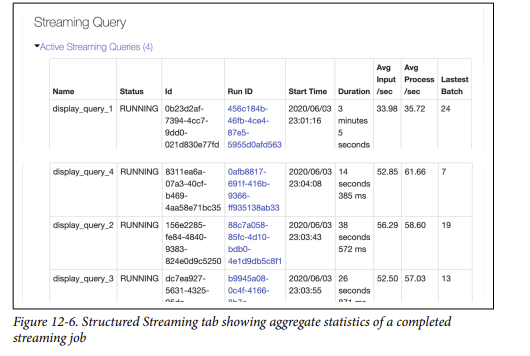
The Figure 12-7 screenshot was taken with Spark 3.0.0-preview2;
with the final release, you should see the query name and ID in the
name identifier on the UI page.
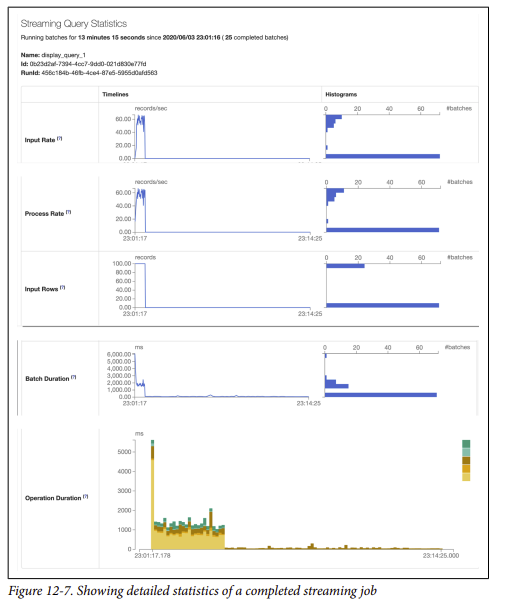
No configuration is required; all configurations works straight out of the Spark 3.0
installation, with the following defaults:
* spark.sql.streaming.ui.enabled=true
* spark.sql.streaming.ui.retainedProgressUpdates=100
* spark.sql.streaming.ui.retainedQueries=100

### PySpark, Pandas UDFs, and Pandas Function APIs
Spark 3.0 requires pandas version 0.23.2 or higher to employ any pandas-related
methods, such as DataFrame.toPandas() or SparkSession.createDataFrame(pan
das.DataFrame).

Furthermore, it requires PyArrow version 0.12.1 or later to use PyArrow functional‐
ity such as pandas_udf(), DataFrame.toPandas(), and SparkSession.createData
Frame(pandas.DataFrame) with the spark.sql.execution.arrow.enabled
configuration set to true. The next section will introduce new features in Pandas
UDFs.
#### Redesigned Pandas UDFs with Python Type Hints
The Pandas UDFs in Spark 3.0 were redesigned by leveraging Python type hints. This
enables you to naturally express UDFs without requiring the evaluation type. Pandas
UDFs are now more “Pythonic” and can themselves define what the UDF is supposed
to input and output, rather than you specifying it via, for example, @pan
das_udf("long", PandasUDFType.SCALAR) as you did in Spark 2.4.
Here’s an example:
~~~
# Pandas UDFs in Spark 3.0
import pandas as pd
from pyspark.sql.functions import pandas_udf
@pandas_udf("long")
def pandas_plus_one(v: pd.Series) -> pd.Series:
 return v + 1
~~~
This new format provides several benefits, such as easier static analysis. You can apply
the new UDFs in the same way as before:
~~~
df = spark.range(3)
df.withColumn("plus_one", pandas_plus_one("id")).show()
~~~
#### Iterator Support in Pandas UDFs
Pandas UDFs are very commonly used to load a model and perform distributed
inference for single-node machine learning and deep learning models. However, if a
model is very large, then there is high overhead for the Pandas UDF to repeatedly
load the same model for every batch in the same Python worker process.

In Spark 3.0, Pandas UDFs can accept an iterator of pandas.Series or pandas.Data
Frame, as shown here:
~~~
from typing import Iterator
@pandas_udf('long')
def pandas_plus_one(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
 return map(lambda s: s + 1, iterator)
df.withColumn("plus_one", pandas_plus_one("id")).show()
+---+--------+
| id|plus_one|
+---+--------+
| 0| 1|
| 1| 2|
| 2| 3|
+---+--------+
~~~
With this support, you can load the model only once instead of loading it for every
series in the iterator. The following pseudocode illustrates how to do this:
~~~
@pandas_udf(...)
def predict(iterator):
 model = ... # load model
 for features in iterator:
 yield model.predict(features)
 ~~~
 #### New Pandas Function APIs
Spark 3.0 introduces a few new types of Pandas UDFs that are useful when you want
to apply a function against an entire DataFrame instead of column-wise, such as
mapInPandas(), introduced in Chapter 11. These take an iterator of pandas.Data
Frame as input and output another iterator of pandas.DataFrame:
~~~
def pandas_filter(
 iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
 for pdf in iterator:
   yield pdf[pdf.id == 1]
df.mapInPandas(pandas_filter, schema=df.schema).show()
+---+
| id|
+---+
| 1|
+---+
~~~
You can control the size of the pandas.DataFrame by specifying it in the
spark.sql.execution.arrow.maxRecordsPerBatch configuration. Note that the
input size and output size do not have to match, unlike with most Pandas UDFs.

All the data of a cogroup will be loaded into memory, which means
if there is data skew or certain groups are too big to fit in memory
you could run into OOM issues.

Spark 3.0 also introduces cogrouped map Pandas UDFs. The applyInPandas() func‐
tion takes two pandas.DataFrames that share a common key and applies a function to
each cogroup. The returned pandas.DataFrames are then combined as a single Data‐
Frame. As with mapInPandas(), there is no restriction on the length of the returned
pandas.DataFrame. Here’s an example:
~~~
df1 = spark.createDataFrame(
 [(1201, 1, 1.0), (1201, 2, 2.0), (1202, 1, 3.0), (1202, 2, 4.0)],
 ("time", "id", "v1"))
df2 = spark.createDataFrame(
 [(1201, 1, "x"), (1201, 2, "y")], ("time", "id", "v2"))
def asof_join(left: pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
 return pd.merge_asof(left, right, on="time", by="id")
df1.groupby("id").cogroup(
 df2.groupby("id")
).applyInPandas(asof_join, "time int, id int, v1 double, v2 string").show()
+----+---+---+---+
|time| id| v1| v2|
+----+---+---+---+
|1201| 1|1.0| x|
|1202| 1|3.0| x|
|1201| 2|2.0| y|
|1202| 2|4.0| y|
+----+---+---+---+
~~~

### Changed Functionality
Listing all the functionality changes in Spark 3.0 would transform this book into a
brick several inches thick. So, in the interest of brevity, we will mention a few notable
ones here, and leave you to consult the release notes for Spark 3.0 for full details and
all the nuances as soon as they are available.
#### Languages Supported and Deprecated
Spark 3.0 supports Python 3 and JDK 11, and Scala version 2.12 is required. All
Python versions earlier than 3.6 and Java 8 are deprecated. If you use these depre‐
cated versions you will get warning messages.
#### Changes to the DataFrame and Dataset APIs
In previous versions of Spark, the Dataset and DataFrame APs had deprecated the
unionAll() method. In Spark 3.0 this has been reversed, and unionAll() is now an
alias to the union() method.

Also, earlier versions of Spark’s Dataset.groupByKey() resulted in a grouped Dataset
with the key spuriously named as value when the key was a non-struct type (int,
string, array, etc.). As such, aggregation results from ds.groupByKey().count() in
the query when displayed looked, counterintuitively, like (value, count). This has
been rectified to result in (key, count), which is more intuitive. For example:
~~~
// In Scala
val ds = spark.createDataset(Seq(20, 3, 3, 2, 4, 8, 1, 1, 3))
ds.show(5)
+-----+
|value|
+-----+
| 20|
| 3|
| 3|
| 2|
| 4|
+-----+
ds.groupByKey(k=> k).count.show(5)
+---+--------+
|key|count(1)|
+---+--------+
| 1| 2|
| 3| 3|
| 20| 1|
| 4| 1|
| 8| 1|
+---+--------+
only showing top 5 rows
~~~
However, you can preserve the old format if you prefer by setting spark.sql.leg
acy.dataset.nameNonStructGroupingKeyAsValue to true.

### DataFrame and SQL Explain Commands
For better readability and formatting, Spark 3.0 introduces the Data
Frame.explain(FORMAT_MODE) capability to display different views of the plans the
Catalyst optimizer generates. The FORMAT_MODE options include "simple" (the
default), "extended", "cost", "codegen", and "formatted". Here’s a simple
illustration:
~~~
// In Scala
val strings = spark
.read.text("/databricks-datasets/learning-spark-v2/SPARK_README.md")
val filtered = strings.filter($"value".contains("Spark"))
filtered.count()
filtered.explain("simple")

== Physical Plan ==
*(1) Project [value#72]
+- *(1) Filter (isnotnull(value#72) AND Contains(value#72, Spark))
 +- FileScan text [value#72] Batched: false, DataFilters: [isnotnull(value#72),
Contains(value#72, Spark)], Format: Text, Location:
InMemoryFileIndex[dbfs:/databricks-datasets/learning-spark-v2/SPARK_README.md],
PartitionFilters: [], PushedFilters: [IsNotNull(value),
StringContains(value,Spark)], ReadSchema: struct<value:string>
// In Scala
filtered.explain("formatted")

== Physical Plan ==
* Project (3)
+- * Filter (2)
 +- Scan text (1)
(1) Scan text
Output [1]: [value#72]
Batched: false
Location: InMemoryFileIndex [dbfs:/databricks-datasets/learning-spark-v2/...
PushedFilters: [IsNotNull(value), StringContains(value,Spark)]
ReadSchema: struct<value:string>

(2) Filter [codegen id : 1]
Input [1]: [value#72]
Condition : (isnotnull(value#72) AND Contains(value#72, Spark))

(3) Project [codegen id : 1]
Output [1]: [value#72]
Input [1]: [value#72]
~~~

~~~
# In Python
strings = spark
.read.text("/databricks-datasets/learning-spark-v2/SPARK_README.md")
filtered = strings.filter(strings.value.contains("Spark"))
filtered.count()
filtered.explain(mode="simple")
filtered.explain(mode="formatted")
~~~

~~~
-- In SQL
EXPLAIN FORMATTED
SELECT *
FROM tmp_spark_readme
WHERE value like "%Spark%"
~~~
To see the rest of the format modes in action, you can try the notebook in the book’s
GitHub repo. Also check out the migration guides from Spark 2.x to Spark 3.0.

## Summary
This chapter provided a cursory highlight of new features in Spark 3.0. We took the
liberty of mentioning a few advanced features that are worthy of note. They operate
under the hood and not at the API level. In particular, we took a look at dynamic par‐
tition pruning (DPP) and adaptive query execution (AQE), two optimizations that
enhance Spark’s performance at execution time. We also explored how the experi‐
mental Catalog API extends the Spark ecosystem to custom data stores for sources
and sinks for both batch and streaming data, and looked at the new scheduler in
Spark 3.0 that enables it to take advantage of GPUs in executors.

Complementing our discussion of the Spark UI in Chapter 7, we also showed you the
new Structured Streaming tab, providing accumulated statistics on streaming jobs,
additional visualizations, and detailed metrics on each query.

Python versions below 3.6 are deprecated in Spark 3.0, and Pandas UDFs have been
redesigned to support Python type hints and iterators as arguments. There are Pandas
UDFs that enable transforming an entire DataFrame, as well as combining two
cogrouped DataFrames into a new DataFrame.

For better readability of query plans, DataFrame.explain(FORMAT_MODE) and
EXPLAIN FORMAT_MODE in SQL display different levels and details of logical and physi‐
cal plans. Additionally, SQL commands can now take join hints for Spark’s entire sup‐
ported family of joins.

While we were unable to enumerate all the changes in the latest version of Spark in
this short chapter, we urge that you explore the release notes when Spark 3.0 is
released to find out more. Also, for a quick summary of the user-facing changes and
details on how to migrate to Spark 3.0, we encourage you to check out the migration
guides.

As a reminder, all the code in this book has been tested on Spark 3.0.0-preview2 and
should work with Spark 3.0 when it is officially released. We hope you’ve enjoyed
reading this book and learned from this journey with us. We thank you for your
attention!